In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from PIL import Image
import os
import random
from sam.sam import SAM
from sam.example.utility.bypass_bn import enable_running_stats, disable_running_stats
from collections import defaultdict

# Loading Dataset (PACS)

In [2]:
MODEL_DIR = '/home/csalt/Haider/ATML/ATML-PA 2/Task2_Models'

In [3]:
DIR_PHOTO = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/photo'
DIR_ART = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/art_painting'
DIR_CARTOON = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/cartoon'
DIR_SKETCH = '/home/csalt/Haider/ATML/ATML-PA 2/PACS/PACS/sketch'

photo_dataset = torchvision.datasets.ImageFolder(DIR_PHOTO)
art_dataset = torchvision.datasets.ImageFolder(DIR_ART)
cartoon_dataset = torchvision.datasets.ImageFolder(DIR_CARTOON)
sketch_dataset = torchvision.datasets.ImageFolder(DIR_SKETCH)

print(f"Photo Dataset: {len(photo_dataset)}")
print(f"Art Dataset: {len(art_dataset)}")
print(f"Cartoon Dataset: {len(cartoon_dataset)}")
print(f"Sketch Dataset: {len(sketch_dataset)}")

Photo Dataset: 1670
Art Dataset: 2048
Cartoon Dataset: 2344
Sketch Dataset: 3929


In [4]:
class PACSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        # PACS has 7 classes
        self.classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        # Collect image paths and labels
        for domain in domains:
            domain_dir = os.path.join(root_dir, domain)
            for class_name in os.listdir(domain_dir):
                if class_name in self.classes:
                    class_dir = os.path.join(domain_dir, class_name)
                    for img_name in os.listdir(class_dir):
                        if img_name.endswith('.jpg') or img_name.endswith('.png'):
                            self.samples.append((
                                os.path.join(class_dir, img_name),
                                self.class_to_idx[class_name],
                                domain
                            ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label, domain = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label, domain

In [5]:
TRAIN_DOMAINS = ['photo', 'art_painting', 'cartoon']
TEST_DOMAINS = ['sketch']

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

pacs_train = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=TRAIN_DOMAINS,
    transform=transform
)
pacs_test = PACSDataset(
    root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',
    domains=TEST_DOMAINS,
    transform=transform
)

In [6]:
train_size = int(0.95 * len(pacs_train))
val_size = len(pacs_train) - train_size
pacs_train_split, pacs_val_split = random_split(pacs_train, [train_size, val_size])

BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# ALTERNATIVELY DO NOT CREATE A VALIDATION SPLIT
pacs_train_loader = DataLoader(pacs_train_split, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
pacs_val_loader = DataLoader(pacs_val_split, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
pacs_test_loader = DataLoader(pacs_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training on {len(pacs_train_split)} images from domains: {', '.join(TRAIN_DOMAINS)}")
print(f"Validating on {len(pacs_val_split)} images from domains: {', '.join(TRAIN_DOMAINS)}")
print(f"Testing on {len(pacs_test)} images from domain: {', '.join(TEST_DOMAINS)}")

Training on 5758 images from domains: photo, art_painting, cartoon
Validating on 304 images from domains: photo, art_painting, cartoon
Testing on 3929 images from domain: sketch


In [7]:
pacs_source_loader = DataLoader(pacs_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

pacs_photo = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['photo'],transform=transform)
pacs_photo_loader = DataLoader(pacs_photo, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

pacs_art_painting = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['art_painting'],transform=transform)
pacs_art_painting_loader = DataLoader(pacs_art_painting, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

pacs_cartoon = PACSDataset(root_dir='/home/csalt/Haider/ATML/Homework3-PACS/PACS',domains=['cartoon'],transform=transform)
pacs_cartoon_loader = DataLoader(pacs_cartoon, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 1) ERM Baseline

In [9]:
erm_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
erm_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
def train_model(model, dataloader, criterion, optimizer, epochs):
    max_validation_accuracy = 0.0
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels, _ in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        avg_train_loss = running_loss / len(dataloader)
        train_accuracies.append(train_acc)
        train_losses.append(avg_train_loss)
        
        print(f"Epoch {epoch+1}")
        print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        
        # ALTERNATIVELY DO NOT VALIDATE
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels, _ in pacs_val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * correct / total
        if val_acc >= max_validation_accuracy:
            max_validation_accuracy = val_acc
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_erm_resnet.pth'))
        avg_val_loss = val_running_loss / len(pacs_val_loader)
        val_accuracies.append(val_acc)
        val_losses.append(avg_val_loss)
        
        print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    
    return train_accuracies, train_losses, val_accuracies, val_losses


In [11]:
erm_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
erm_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(erm_resnet_pacs.fc.in_features, len(pacs_train.classes))
)
for m in erm_resnet_pacs.modules():
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        m.eval()
        for param in m.parameters():
            param.requires_grad = False

# for m in erm_resnet_pacs.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         m.eval()
                
erm_resnet_pacs = erm_resnet_pacs.to(DEVICE)
erm_resnet_pacs_criterion = torch.nn.CrossEntropyLoss()
erm_resnet_pacs_optimizer = optim.Adam(erm_resnet_pacs.parameters(), lr=0.001)

In [13]:
print("Fine-tuning ResNet-50 on PACS dataset...")
resnet_pacs_train_acc, resnet_pacs_train_loss, resnet_pacs_val_acc, resnet_pacs_val_loss = train_model(
    model=erm_resnet_pacs,
    dataloader=pacs_train_loader,
    criterion=erm_resnet_pacs_criterion,
    optimizer=erm_resnet_pacs_optimizer,
    epochs=50
)
torch.save(erm_resnet_pacs.state_dict(), os.path.join(MODEL_DIR, 'erm_resnet.pth'))

Fine-tuning ResNet-50 on PACS dataset...


Epoch 1
	Training Loss: 0.6916, Train Acc: 77.77%
	Validation Loss: 0.4359, Validation Acc: 85.53%
Epoch 2
	Training Loss: 0.3405, Train Acc: 88.89%
	Validation Loss: 0.3334, Validation Acc: 90.46%
Epoch 3
	Training Loss: 0.2232, Train Acc: 92.71%
	Validation Loss: 0.5244, Validation Acc: 85.20%
Epoch 4
	Training Loss: 0.1865, Train Acc: 94.10%
	Validation Loss: 0.5289, Validation Acc: 84.87%
Epoch 5
	Training Loss: 0.1453, Train Acc: 95.33%
	Validation Loss: 0.6429, Validation Acc: 83.55%
Epoch 6
	Training Loss: 0.1508, Train Acc: 95.28%
	Validation Loss: 0.3652, Validation Acc: 89.47%
Epoch 7
	Training Loss: 0.0990, Train Acc: 96.89%
	Validation Loss: 0.3587, Validation Acc: 89.14%
Epoch 8
	Training Loss: 0.0678, Train Acc: 97.99%
	Validation Loss: 0.3441, Validation Acc: 89.80%
Epoch 9
	Training Loss: 0.0797, Train Acc: 97.43%
	Validation Loss: 0.2969, Validation Acc: 92.11%
Epoch 10
	Training Loss: 0.0845, Train Acc: 97.36%
	Validation Loss: 0.1922, Validation Acc: 92.76%
Epoch 11


In [12]:
def compute_accuracy(model, dataloader):
    model.to(DEVICE)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels, _ = batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    return 100.0 * correct / total if total > 0 else float("nan")

## Evaluate ERM Model - Best Checkpoint 

In [15]:
erm_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_erm_resnet.pth')))

<All keys matched successfully>

### Target Domain Evaluation (Best)

In [16]:
sketch_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_erm:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 66.76%


### Source Domain Evaluation (Best)

In [17]:
source_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_erm:.2f}%")

source_photo_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_erm:.2f}%")

source_art_painting_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_erm:.2f}%")

source_cartoon_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_erm:.2f}%")

domain_accuracies = [source_photo_accuracy_erm, source_art_painting_accuracy_erm, source_cartoon_accuracy_erm]
worst_group_acc_erm = min(domain_accuracies)
avg_source_acc_erm = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_erm:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_erm:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 99.60%
ResNet-50 Accuracy on PACS Art Painting Domain: 99.64%
ResNet-50 Accuracy on PACS Art Domain: 99.41%
ResNet-50 Accuracy on PACS Cartoon Domain: 99.74%

Worst-group accuracy (source domains): 99.41%
Average accuracy (source domains): 99.60%


## Evaluate ERM Model - Last Checkpoint 

In [18]:
erm_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'erm_resnet.pth')))

<All keys matched successfully>

### Target Domain Evaluation (Last)

In [19]:
sketch_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_erm:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 65.05%


### Source Domain Evaluation (Last)

In [20]:
source_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_erm:.2f}%")

source_photo_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_erm:.2f}%")

source_art_painting_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_erm:.2f}%")

source_cartoon_accuracy_erm = compute_accuracy(erm_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_erm:.2f}%")

domain_accuracies = [source_photo_accuracy_erm, source_art_painting_accuracy_erm, source_cartoon_accuracy_erm]
worst_group_acc_erm = min(domain_accuracies)
avg_source_acc_erm = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_erm:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_erm:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 99.52%
ResNet-50 Accuracy on PACS Art Painting Domain: 99.70%
ResNet-50 Accuracy on PACS Art Domain: 99.32%
ResNet-50 Accuracy on PACS Cartoon Domain: 99.57%

Worst-group accuracy (source domains): 99.32%
Average accuracy (source domains): 99.53%


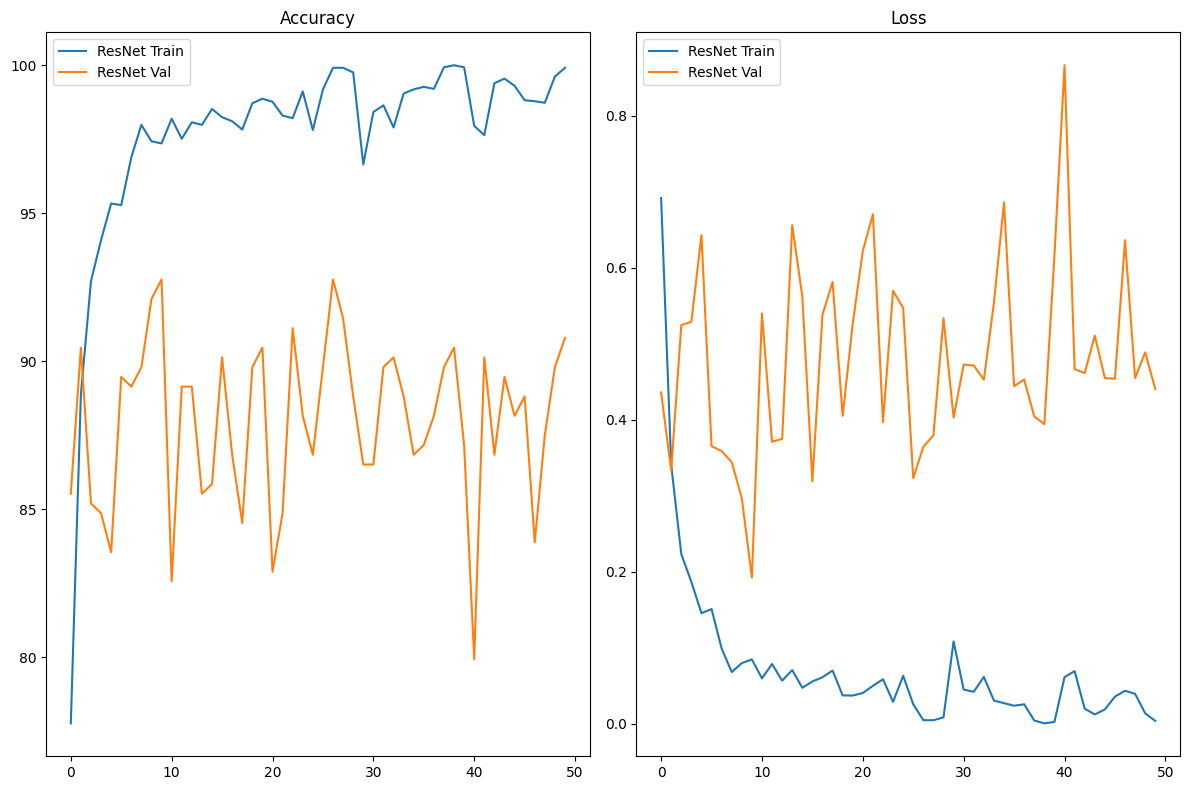

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(resnet_pacs_train_acc, label='ResNet Train')
plt.plot(resnet_pacs_val_acc, label='ResNet Val')
plt.title('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(resnet_pacs_train_loss, label='ResNet Train')
plt.plot(resnet_pacs_val_loss, label='ResNet Val')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 4) SAM

In [9]:
EPOCHS = 50

In [14]:
sam_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
sam_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sam_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(sam_resnet_pacs.fc.in_features, len(pacs_train.classes))
)
for m in sam_resnet_pacs.modules():
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        m.eval()
        for param in m.parameters():
            param.requires_grad = False

sam_resnet_pacs = sam_resnet_pacs.to(DEVICE)
sam_resnet_pacs_criterion = torch.nn.CrossEntropyLoss()
sam_resnet_pacs_base_optimizer = optim.SGD
sam_resnet_pacs_optimizer_0_05 = SAM(sam_resnet_pacs.parameters(), sam_resnet_pacs_base_optimizer, \
    rho=0.05, adaptive=False, lr=0.01)

max_validation_accuracy = 0.0
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    sam_resnet_pacs.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for images, labels, _ in pacs_train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        enable_running_stats(sam_resnet_pacs)
        outputs = sam_resnet_pacs(images)
        loss = sam_resnet_pacs_criterion(outputs, labels)
        loss.backward()
        sam_resnet_pacs_optimizer_0_05.first_step(zero_grad=True)

        # second forward-backward step
        disable_running_stats(sam_resnet_pacs)
        sam_resnet_pacs_criterion(sam_resnet_pacs(images), labels).backward()
        sam_resnet_pacs_optimizer_0_05.second_step(zero_grad=True)

        with torch.no_grad():
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * correct / total
    avg_train_loss = running_loss / len(pacs_train_loader)
    train_accuracies.append(train_acc)
    train_losses.append(avg_train_loss)
    
    print(f"Epoch {epoch}")
    print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    sam_resnet_pacs.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, _ in pacs_val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = sam_resnet_pacs(images)
            loss = sam_resnet_pacs_criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * correct / total
    if val_acc >= max_validation_accuracy:
        max_validation_accuracy = val_acc
        torch.save(sam_resnet_pacs.state_dict(), os.path.join(MODEL_DIR, 'best_sam_resnet_0_05.pth'))
    avg_val_loss = val_running_loss / len(pacs_val_loader)
    val_accuracies.append(val_acc)
    val_losses.append(avg_val_loss)
    
    print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
    print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

torch.save(sam_resnet_pacs.state_dict(),  os.path.join(MODEL_DIR, 'sam_resnet_0_05.pth'))

Epoch 1
	Training Loss: 1.0079, Train Acc: 75.10%
	Validation Loss: 0.3931, Validation Acc: 93.09%
	ResNet-50 Accuracy on PACS Sketch Domain: 47.39%
Epoch 2
	Training Loss: 0.2980, Train Acc: 93.19%
	Validation Loss: 0.1929, Validation Acc: 95.72%
	ResNet-50 Accuracy on PACS Sketch Domain: 61.57%
Epoch 3
	Training Loss: 0.1684, Train Acc: 96.14%
	Validation Loss: 0.1579, Validation Acc: 95.72%
	ResNet-50 Accuracy on PACS Sketch Domain: 64.32%
Epoch 4
	Training Loss: 0.1163, Train Acc: 97.17%
	Validation Loss: 0.1376, Validation Acc: 96.71%
	ResNet-50 Accuracy on PACS Sketch Domain: 62.51%
Epoch 5
	Training Loss: 0.0864, Train Acc: 98.28%
	Validation Loss: 0.1106, Validation Acc: 97.04%
	ResNet-50 Accuracy on PACS Sketch Domain: 66.73%
Epoch 6
	Training Loss: 0.0631, Train Acc: 98.91%
	Validation Loss: 0.1058, Validation Acc: 97.04%
	ResNet-50 Accuracy on PACS Sketch Domain: 67.29%
Epoch 7
	Training Loss: 0.0541, Train Acc: 99.01%
	Validation Loss: 0.1050, Validation Acc: 97.04%
	ResNet

In [ ]:
sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

source_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_sam:.2f}%")

source_photo_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Photo Domain: {source_photo_accuracy_sam:.2f}%")

source_art_painting_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_sam:.2f}%")

source_cartoon_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_sam:.2f}%")

domain_accuracies = [source_photo_accuracy_sam, source_art_painting_accuracy_sam, source_cartoon_accuracy_sam]
worst_group_acc_sam = min(domain_accuracies)
avg_source_acc_sam = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_sam:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_sam:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 66.00%
ResNet-50 Accuracy on PACS Source Domains: 99.44%
ResNet-50 Accuracy on PACS Art Painting Domain: 99.94%
ResNet-50 Accuracy on PACS Art Domain: 99.46%
ResNet-50 Accuracy on PACS Cartoon Domain: 99.06%

Worst-group accuracy (source domains): 99.06%
Average accuracy (source domains): 99.49%


# 0.01

In [15]:
sam_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
sam_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sam_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(sam_resnet_pacs.fc.in_features, len(pacs_train.classes))
)
for m in sam_resnet_pacs.modules():
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        m.eval()
        for param in m.parameters():
            param.requires_grad = False

sam_resnet_pacs = sam_resnet_pacs.to(DEVICE)
sam_resnet_pacs_criterion = torch.nn.CrossEntropyLoss()
sam_resnet_pacs_base_optimizer = optim.SGD
sam_resnet_pacs_optimizer_0_01 = SAM(sam_resnet_pacs.parameters(), sam_resnet_pacs_base_optimizer, \
    rho=0.01, adaptive=False, lr=0.01)
max_validation_accuracy = 0.0
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    sam_resnet_pacs.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for images, labels, _ in pacs_train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        enable_running_stats(sam_resnet_pacs)
        outputs = sam_resnet_pacs(images)
        loss = sam_resnet_pacs_criterion(outputs, labels)
        loss.backward()
        sam_resnet_pacs_optimizer_0_01.first_step(zero_grad=True)

        # second forward-backward step
        disable_running_stats(sam_resnet_pacs)
        sam_resnet_pacs_criterion(sam_resnet_pacs(images), labels).backward()
        sam_resnet_pacs_optimizer_0_01.second_step(zero_grad=True)

        with torch.no_grad():
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * correct / total
    avg_train_loss = running_loss / len(pacs_train_loader)
    train_accuracies.append(train_acc)
    train_losses.append(avg_train_loss)
    
    print(f"Epoch {epoch}")
    print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    sam_resnet_pacs.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, _ in pacs_val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = sam_resnet_pacs(images)
            loss = sam_resnet_pacs_criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * correct / total
    if val_acc >= max_validation_accuracy:
        max_validation_accuracy = val_acc
        torch.save(sam_resnet_pacs.state_dict(), os.path.join(MODEL_DIR, 'best_sam_resnet_0_01.pth'))
    avg_val_loss = val_running_loss / len(pacs_val_loader)
    val_accuracies.append(val_acc)
    val_losses.append(avg_val_loss)
    
    print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
    print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

torch.save(sam_resnet_pacs.state_dict(),  os.path.join(MODEL_DIR, 'sam_resnet_0_01.pth'))

Epoch 1
	Training Loss: 0.9506, Train Acc: 75.51%
	Validation Loss: 0.3614, Validation Acc: 91.78%
	ResNet-50 Accuracy on PACS Sketch Domain: 59.10%
Epoch 2
	Training Loss: 0.2655, Train Acc: 93.12%
	Validation Loss: 0.1963, Validation Acc: 95.39%
	ResNet-50 Accuracy on PACS Sketch Domain: 58.54%
Epoch 3
	Training Loss: 0.1491, Train Acc: 96.04%
	Validation Loss: 0.1641, Validation Acc: 95.07%
	ResNet-50 Accuracy on PACS Sketch Domain: 61.70%
Epoch 4
	Training Loss: 0.0888, Train Acc: 97.95%
	Validation Loss: 0.1419, Validation Acc: 96.05%
	ResNet-50 Accuracy on PACS Sketch Domain: 63.71%
Epoch 5
	Training Loss: 0.0663, Train Acc: 98.44%
	Validation Loss: 0.1351, Validation Acc: 96.38%
	ResNet-50 Accuracy on PACS Sketch Domain: 65.11%
Epoch 6
	Training Loss: 0.0442, Train Acc: 99.10%
	Validation Loss: 0.1286, Validation Acc: 96.38%
	ResNet-50 Accuracy on PACS Sketch Domain: 67.68%
Epoch 7
	Training Loss: 0.0326, Train Acc: 99.44%
	Validation Loss: 0.1278, Validation Acc: 96.38%
	ResNet

In [16]:
sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

source_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_sam:.2f}%")

source_photo_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Photo Domain: {source_photo_accuracy_sam:.2f}%")

source_art_painting_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_sam:.2f}%")

source_cartoon_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_sam:.2f}%")

domain_accuracies = [source_photo_accuracy_sam, source_art_painting_accuracy_sam, source_cartoon_accuracy_sam]
worst_group_acc_sam = min(domain_accuracies)
avg_source_acc_sam = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_sam:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_sam:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 69.15%
ResNet-50 Accuracy on PACS Source Domains: 99.85%
ResNet-50 Accuracy on PACS Photo Domain: 99.94%
ResNet-50 Accuracy on PACS Art Domain: 99.85%
ResNet-50 Accuracy on PACS Cartoon Domain: 99.79%

Worst-group accuracy (source domains): 99.79%
Average accuracy (source domains): 99.86%


# 0.1

In [17]:
sam_resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(DEVICE)
sam_resnet_pacs = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
sam_resnet_pacs.fc = nn.Sequential(
    nn.Dropout(p=0.25),
    nn.Linear(sam_resnet_pacs.fc.in_features, len(pacs_train.classes))
)
for m in sam_resnet_pacs.modules():
    if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
        m.eval()
        for param in m.parameters():
            param.requires_grad = False

sam_resnet_pacs = sam_resnet_pacs.to(DEVICE)
sam_resnet_pacs_criterion = torch.nn.CrossEntropyLoss()
sam_resnet_pacs_base_optimizer = optim.SGD
sam_resnet_pacs_optimizer_0_1 = SAM(sam_resnet_pacs.parameters(), sam_resnet_pacs_base_optimizer, \
    rho=0.1, adaptive=False, lr=0.01)
max_validation_accuracy = 0.0
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    sam_resnet_pacs.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for images, labels, _ in pacs_train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        enable_running_stats(sam_resnet_pacs)
        outputs = sam_resnet_pacs(images)
        loss = sam_resnet_pacs_criterion(outputs, labels)
        loss.backward()
        sam_resnet_pacs_optimizer_0_1.first_step(zero_grad=True)

        # second forward-backward step
        disable_running_stats(sam_resnet_pacs)
        sam_resnet_pacs_criterion(sam_resnet_pacs(images), labels).backward()
        sam_resnet_pacs_optimizer_0_1.second_step(zero_grad=True)

        with torch.no_grad():
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * correct / total
    avg_train_loss = running_loss / len(pacs_train_loader)
    train_accuracies.append(train_acc)
    train_losses.append(avg_train_loss)
    
    print(f"Epoch {epoch}")
    print(f"\tTraining Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    
    sam_resnet_pacs.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, _ in pacs_val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = sam_resnet_pacs(images)
            loss = sam_resnet_pacs_criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * correct / total
    if val_acc >= max_validation_accuracy:
        max_validation_accuracy = val_acc
        torch.save(sam_resnet_pacs.state_dict(), os.path.join(MODEL_DIR, 'best_sam_resnet_0_1.pth'))
    avg_val_loss = val_running_loss / len(pacs_val_loader)
    val_accuracies.append(val_acc)
    val_losses.append(avg_val_loss)
    
    print(f"\tValidation Loss: {avg_val_loss:.4f}, Validation Acc: {val_acc:.2f}%")
    sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
    print(f"\tResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

torch.save(sam_resnet_pacs.state_dict(),  os.path.join(MODEL_DIR, 'sam_resnet_0_1.pth'))

Epoch 1
	Training Loss: 1.0566, Train Acc: 74.37%
	Validation Loss: 0.4715, Validation Acc: 92.43%
	ResNet-50 Accuracy on PACS Sketch Domain: 50.55%
Epoch 2
	Training Loss: 0.3471, Train Acc: 91.89%
	Validation Loss: 0.2499, Validation Acc: 93.42%
	ResNet-50 Accuracy on PACS Sketch Domain: 60.83%
Epoch 3
	Training Loss: 0.2114, Train Acc: 95.05%
	Validation Loss: 0.1845, Validation Acc: 95.07%
	ResNet-50 Accuracy on PACS Sketch Domain: 63.76%
Epoch 4
	Training Loss: 0.1590, Train Acc: 96.77%
	Validation Loss: 0.1594, Validation Acc: 95.39%
	ResNet-50 Accuracy on PACS Sketch Domain: 64.57%
Epoch 5
	Training Loss: 0.1282, Train Acc: 97.26%
	Validation Loss: 0.1370, Validation Acc: 96.38%
	ResNet-50 Accuracy on PACS Sketch Domain: 65.92%
Epoch 6
	Training Loss: 0.1024, Train Acc: 98.11%
	Validation Loss: 0.1277, Validation Acc: 96.71%
	ResNet-50 Accuracy on PACS Sketch Domain: 67.04%
Epoch 7
	Training Loss: 0.0796, Train Acc: 98.63%
	Validation Loss: 0.1172, Validation Acc: 96.71%
	ResNet

In [18]:
sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

source_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_sam:.2f}%")

source_photo_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Photo Domain: {source_photo_accuracy_sam:.2f}%")

source_art_painting_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_sam:.2f}%")

source_cartoon_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_sam:.2f}%")

domain_accuracies = [source_photo_accuracy_sam, source_art_painting_accuracy_sam, source_cartoon_accuracy_sam]
worst_group_acc_sam = min(domain_accuracies)
avg_source_acc_sam = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_sam:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_sam:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 70.48%
ResNet-50 Accuracy on PACS Source Domains: 99.88%
ResNet-50 Accuracy on PACS Photo Domain: 99.94%
ResNet-50 Accuracy on PACS Art Domain: 99.90%
ResNet-50 Accuracy on PACS Cartoon Domain: 99.83%

Worst-group accuracy (source domains): 99.83%
Average accuracy (source domains): 99.89%


## Evaluate SAM Model - Best Checkpoint 

In [ ]:
sam_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_sam_resnet.pth')))

<All keys matched successfully>

### Target Domain Evaluation (Best)

In [ ]:
sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 72.10%


### Source Domain Evaluation (Best)

In [ ]:
sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

source_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_sam:.2f}%")

source_photo_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_sam:.2f}%")

source_art_painting_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_sam:.2f}%")

source_cartoon_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_sam:.2f}%")

domain_accuracies = [source_photo_accuracy_sam, source_art_painting_accuracy_sam, source_cartoon_accuracy_sam]
worst_group_acc_sam = min(domain_accuracies)
avg_source_acc_sam = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_sam:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_sam:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 99.95%
ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
ResNet-50 Accuracy on PACS Art Domain: 99.85%
ResNet-50 Accuracy on PACS Cartoon Domain: 100.00%


## Evaluate SAM Model - Last Checkpoint 

In [ ]:
sam_resnet_pacs.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'sam_resnet.pth')))

<All keys matched successfully>

### Target Domain Evaluation (Last)

In [ ]:
sketch_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_test_loader)
print(f"ResNet-50 Accuracy on PACS Sketch Domain: {sketch_accuracy_sam:.2f}%")

ResNet-50 Accuracy on PACS Sketch Domain: 73.07%


### Source Domain Evaluation (Last)

In [ ]:
source_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_source_loader)
print(f"ResNet-50 Accuracy on PACS Source Domains: {source_accuracy_sam:.2f}%")

source_photo_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_photo_loader)
print(f"ResNet-50 Accuracy on PACS Art Painting Domain: {source_photo_accuracy_sam:.2f}%")

source_art_painting_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_art_painting_loader)
print(f"ResNet-50 Accuracy on PACS Art Domain: {source_art_painting_accuracy_sam:.2f}%")

source_cartoon_accuracy_sam = compute_accuracy(sam_resnet_pacs, pacs_cartoon_loader)
print(f"ResNet-50 Accuracy on PACS Cartoon Domain: {source_cartoon_accuracy_sam:.2f}%")

domain_accuracies = [source_photo_accuracy_sam, source_art_painting_accuracy_sam, source_cartoon_accuracy_sam]
worst_group_acc_sam = min(domain_accuracies)
avg_source_acc_sam = np.mean(domain_accuracies)
print(f"\nWorst-group accuracy (source domains): {worst_group_acc_sam:.2f}%")
print(f"Average accuracy (source domains): {avg_source_acc_sam:.2f}%")

ResNet-50 Accuracy on PACS Source Domains: 99.92%
ResNet-50 Accuracy on PACS Art Painting Domain: 100.00%
ResNet-50 Accuracy on PACS Art Domain: 99.80%
ResNet-50 Accuracy on PACS Cartoon Domain: 99.96%


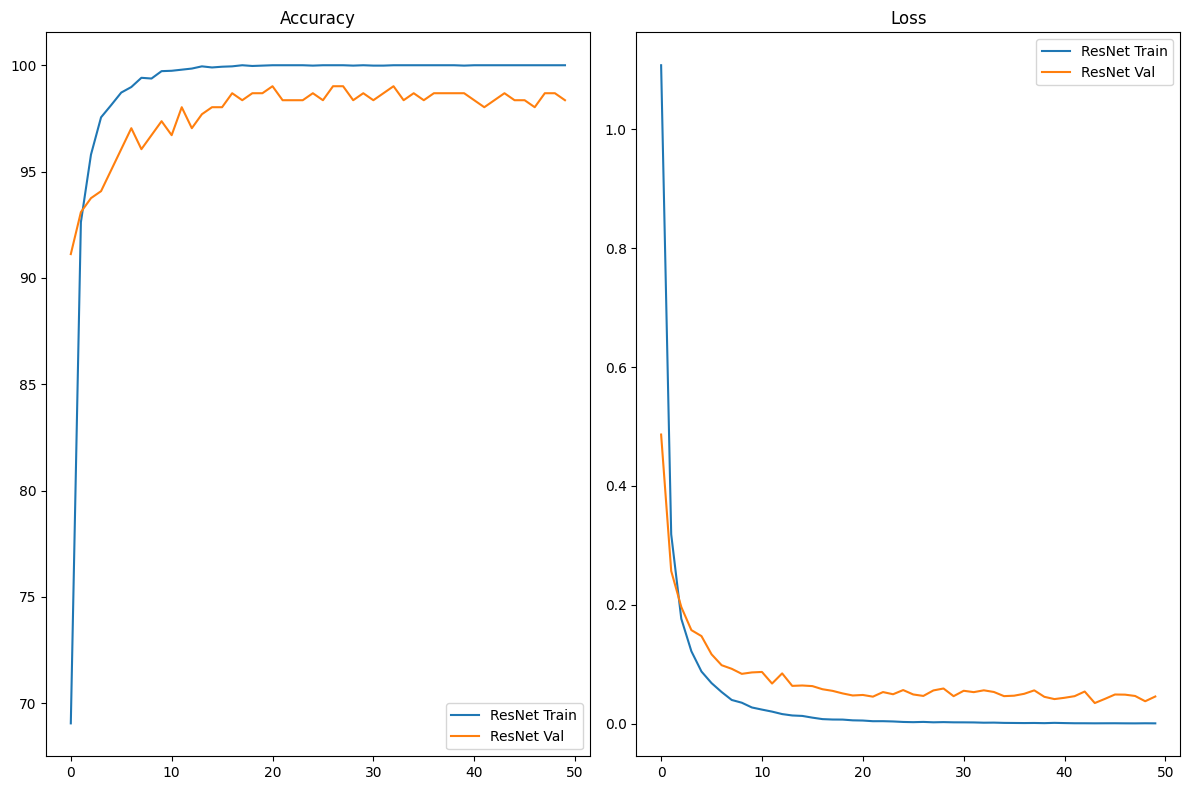

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='ResNet Train')
plt.plot(val_accuracies, label='ResNet Val')
plt.title('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_losses, label='ResNet Train')
plt.plot(val_losses, label='ResNet Val')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()